# Анализ пользователей мобильного приложения по продаже продуктов питания

## Описание проекта
    
Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно, поэтому договорились принять решение по рузультатам A/A/B - теста. Для этого пользователей разбили на 3 группы: две контрольные со старыми шрифтами и одну экспериментальную - с новыми. 

**Цель исследования:** разобраться в поведении пользователей, которые покупают продукты питания через мобильное приложение одного из стартапов. Необходимо изучить воронку продаж и узнать, как пользователи доходят до покупки, сколько пользователей совершают покупки, а сколько застревают на предыдущих шагах и на каких именно. 
Также, необходимо исследовать результаты A/A/B - эксперимента и принять решение о том, какой шрифт лучше. 

**Ход исследования** - данные о действиях пользователей будут получены из файла. О качестве данных заранее ничего неизвестно, поэтому перед тем, как приступить к основной части проекта, понадобится получить первые впечатления о данных, после чего проверить их на качество и наличие в них различных ошибок, пропусков и аномалий, если что-то подобное присутствует, на этапе предобработки необходимо будет исправить самые критичные ошибки и привести датафрейм к нормальному, рабочему состоянию. 

Стоит заметить, что создание двух групп А вместо одной имеет определённые преимущества: если две контрольные группы окажутся равны, можно быть уверенным в точности проведённого тестирования. Если же между значениями А и А будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов. 

Таким образом, исследование пройдёт в четыре этапа:
 1. Обзор данных.
 2. Предобработка данных.
 3. Исследовательский анализ данных.
 4. Проведение A/A-теста
 5. Проведение A/B-теста
 6. Итоговые выводы по работе

## 1. Обзор данных

На данном этапе будет сформирована первая картина о данных, с которыми предстоит работать. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth
import statistics as s
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('seaborn-dark') 

In [2]:
try:
    df = pd.read_csv('Данные сборного проекта - 2 "logs_exp.csv"', sep = '\t')
except:
    df = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')

In [3]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
# Получение общей информации о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Согласно документации к данным:
* `EventName` — название события;
* `DeviceIDHash` — уникальный идентификатор пользователя; 
* `EventTimestamp` — время события;
* `ExpId` — номер эксперимента: 246 и 247 - контрольные группы, а 248 - экспериментальная

**Вывод по 1-ому разделу**

После получения общей информации, в таблице были выявлены следующие замечания:
1. Названия столбцов написаны не с помощью змеиного регистра
2. В столбце `EventTimestamp` находится дата, однако тип данных там - целое число
3. Пропущенный значений в таблице не наблюдается

## 2. Предобработка данных

На данном этапе будут устранены выявленные проблемы в данных с целью корректной работы с ними на протяжение всего проекта. 

In [5]:
# Приводим название столбцов к змеиному регистру
df = df.rename(
    columns = 
    {'EventName': 'event_name', 'DeviceIDHash': 'device_id_hash', 'EventTimestamp': 'event_time', 'ExpId': 'exp_id'}
               )

In [6]:
# Приводим столбец с датой к нужному типу
df['event_time'] = df['event_time'].astype('datetime64[s]')

In [7]:
# Проверяем датафрейм на наличие явных дубликатов
cnt_dupl = df.duplicated().sum()

In [8]:
# Проверяем, какой процент составляют дубликаты от общего количества данных
print(f'Полные дубликаты в абсолютном значении составляют {cnt_dupl} штук, а в относительном - {cnt_dupl / len(df):.2%} от первоначального датафрейма')

Полные дубликаты в абсолютном значении составляют 413 штук, а в относительном - 0.17% от первоначального датафрейма


In [9]:
# Удаляем явные дубликаты
df = df.drop_duplicates()

In [10]:
# Проверяем столбец event_name на наличие неявных дубликатов
df['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [11]:
# Проверяем столбец exp_id на наличие неявных дубликатов
df['exp_id'].unique()

array([246, 248, 247])

In [12]:
df.head()

,event_name,device_id_hash,event_time,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


**Вывод по 2-ому разделу**

Во 2 разделе данные были приведены в удобный и верный для работы формат. Также, в логе были выявлены полные дубликаты, которые составили 0.17% от первоначального датасета, что крайне мало, поэтому было решено их удалить (было удалено 413 явного дубликата). После проделанной предобработки данных можно приступать к основной части проекта.

## 3. Исследовательский анализ данных

In [13]:
# Добавляем столбец с датой
df['date'] = df['event_time'].dt.date

In [14]:
# Находим количество событий в логе
cnt_events = df.shape[0]
print(f'Количество событий в логе: {cnt_events}')

Количество событий в логе: 243713


In [15]:
# Находим уникальное количество пользователей в логе
unique_users = df['device_id_hash'].nunique()
print(f'Уникальное количество пользователей в логе: {unique_users}')

Уникальное количество пользователей в логе: 7551


In [16]:
# Находим среднее количество событий, приходящихся на пользователя
cnt_events = df.pivot_table(index='event_name', values='device_id_hash', aggfunc='count', margins=True)
cnt_events.columns = ['cnt_events']
cnt_events['avg_events_per_users'] = cnt_events['cnt_events'] / unique_users
cnt_events = cnt_events.reset_index()
cnt_events.sort_values(by='cnt_events', ascending=False)

,event_name,cnt_events,avg_events_per_users
5,All,243713,32.275593
1,MainScreenAppear,119101,15.772878
2,OffersScreenAppear,46808,6.198914
0,CartScreenAppear,42668,5.650642
3,PaymentScreenSuccessful,34118,4.518342
4,Tutorial,1018,0.134817


In [17]:
stats_df = df.groupby(['device_id_hash'])[['event_name']].count()
stats_df.columns = ['cnt_events']
stats_df = stats_df.reset_index()
#stats_df = stats_df.groupby('device_id_hash')[['cnt_events']].agg({'cnt_events':['count', 'median', 'mean', pd.Series.mode]})
print(f'Медиана по количеству событий на пользователя равна {stats_df["cnt_events"].median()}')
print(f'Средний показатель количества событий на пользователя равен {stats_df["cnt_events"].mean()}')
print(f'Мода количества событий на пользователя равна {stats_df["cnt_events"].mode()}')

Медиана по количеству событий на пользователя равна 20.0
Средний показатель количества событий на пользователя равен 32.27559263673685
Мода количества событий на пользователя равна 0    5
dtype: int64


In [18]:
min_date = df['date'].min()
max_date = df['date'].max()
print(f'Минимальная дата события: {min_date}')
print(f'Максимальная дата события: {max_date}')

Минимальная дата события: 2019-07-25
Максимальная дата события: 2019-08-07


Период для анализа, которым я располагаю, начинаются с 25 июля 2019 года и заканчиваются 7 августом того же года. 

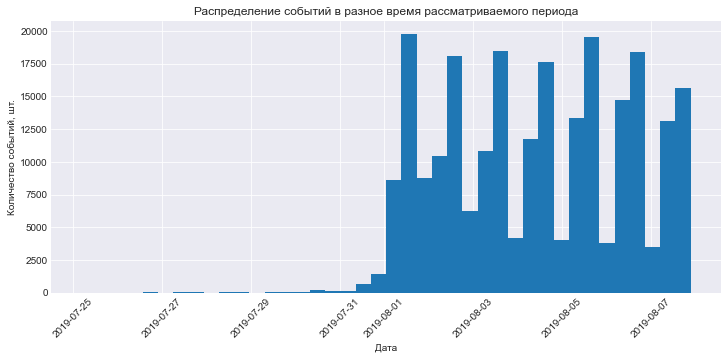

In [19]:
df['event_time'].hist(bins=40, figsize=(12, 5))
plt.xticks(rotation=45)
plt.title('Распределение событий в разное время рассматриваемого периода')
plt.ylabel('Количество событий, шт.')
plt.xlabel('Дата');

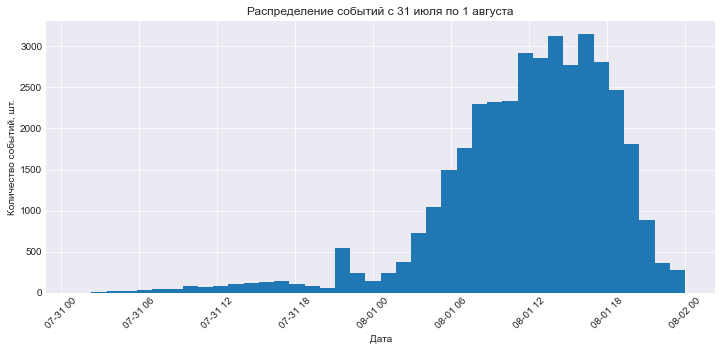

In [20]:
# Рассматриваем данные за 31 июля - 1 августа более подробно
detailed_df = df[(df['event_time'] >= '2019-07-31') & (df['event_time'] <= '2019-08-02')]
detailed_df['event_time'].hist(bins=40, figsize=(12, 5))
plt.xticks(rotation=45)
plt.title('Распределение событий c 31 июля по 1 августа')
plt.ylabel('Количество событий, шт.')
plt.xlabel('Дата');

**Вывод**

На данной гистограмме можем заметить, что в какие-то моменты количество событий сильно проседает, а в какие-то - их и вовсе почти нет, поэтому можно сделать вывод о том, что передо мной не одинаково полные данные за весь рассматриваемый период. Следовательно, необходимо оставить в датафрейме только тот период, который необходим и полезен для анализа. Судя по гистограмме, начальной точкой отсчёта целесообразно считать 1 августа 2019 года, так как именно в этот день начинается всплеск событий, что говорит о наполнении лога данными, тем самым останется именно тот промежуток, в котором данные будут полными и более новыми.

Исходя из более детализированной гистограммы, стоит также предположить, что тест был запущен 1 августа в 00 часов по Москве, но так как при импорте данных не были утчены часовые пояса (да и в задании этого нет), то видно, что тест был начат в 21 час 31 июля по Лондонскому времени, так как примерно на этом промежутке времени начинается реальная пользовательская активность и уже совершённые пользователями действия, события записывается в лог.

In [21]:
# Отсекаем более старые данные
df_actual = df[df['event_time'] >= '2019-08-01']

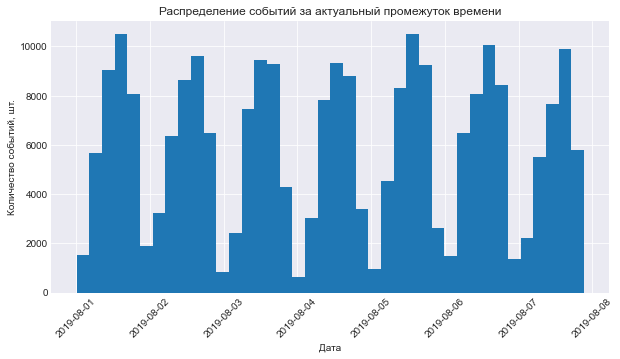

In [22]:
# Визуализация распределения после очистки от старых данных
df_actual['event_time'].hist(bins=40, figsize=(10,5))
plt.xticks(rotation=45)
plt.title('Распределение событий за актуальный промежуток времени')
plt.ylabel('Количество событий, шт.')
plt.xlabel('Дата');

Ранее, из датафрейма были удалены более старые данные, поэтому новый и актуальный период анализа получаем в рамках восьми дней: с 1 августа 2019 года по 8 августа того же года.

Анализируя гистограмму по более новым данным, видим некие скачки, которые, на мой взгляд, достаточно логичны: примерно к середине каждого дня люди активизируются и показывают максимальную активность в приложении, а уже ближе к ночи - их активность затихает и в этот промежуток времени видна минимальная активность. Также можем заметить, что в каждый из дней представлено нормальное распределение событий.

In [23]:
# Определяем количество старых данных, которые пришлось срезать
df_not_actual = df[df['event_time'] < '2019-08-01']
len(df_not_actual)

2826

In [24]:
# Считаем, какой процент неактуальных данных у нас был в изначальном датафрейме
not_actual_data = len(df_not_actual) / len(df)
print(f'В абсолютном значении количество неактуальных данных равно {len(df_not_actual)}')
print(f'Доля старых данных по отношению к более новым составляет {not_actual_data:.2%}')

В абсолютном значении количество неактуальных данных равно 2826
Доля старых данных по отношению к более новым составляет 1.16%


Количество неактуальных данных составляет 2826 записей, а если говорить об относительном показателе, то их доля составляет 1.2% от всего датасета, это достаточно маленький показатель, следовательно, удаление такого количество никак не исказит и не повляет на итоговый результат.

In [25]:
print(f'В итоге было принято удалить {len(df_not_actual) + cnt_dupl} записей, что составляет {(len(df_not_actual) + cnt_dupl) / len(df):.2%} от всех данных')
print(f'После всех преобразований датафрейма, в моём распоряжении имеется {len(df_actual)} записей о пользователях')

В итоге было принято удалить 3239 записей, что составляет 1.33% от всех данных
После всех преобразований датафрейма, в моём распоряжении имеется 240887 записей о пользователях


In [26]:
# Считаем, какую долю пользователей удалили
initial_amount_persons = df['device_id_hash'].nunique()
actual_persons = df_actual['device_id_hash'].nunique()
print(f'Количество удалённых пользователей в абсолютном выражении равно {initial_amount_persons - actual_persons}')
print(f'Доля пользователей, которую удалили, по отношению к изначальному количеству, равна {1 - actual_persons / initial_amount_persons:.2%}')
print(f'После удаления пользователей, попавших в неактуальный промежуток, для анализа осталось {df_actual["device_id_hash"].nunique()} пользователя')

Количество удалённых пользователей в абсолютном выражении равно 17
Доля пользователей, которую удалили, по отношению к изначальному количеству, равна 0.23%
После удаления пользователей, попавших в неактуальный промежуток, для анализа осталось 7534 пользователя


**Промежуточный вывод**

После некоторых преобразований, можно сделать следующие выводы:
1. Всего было принято удалить 3239 записей, из них 413 полных дубликатов и 2826 неактуальных данных, что составляет 1.33% от первоначального датасета. Удаление подобного количества записей никак не отразится на итоговом результате.
2. В связи с выявленным неактуальным промежутком времени, вместе со всеми событиями за этот период, были удалены и сами пользователи, которые попали в этот отрезок: в абсолютном выражении это число составило 17 человек, а в относительном (по отношению к изначальному количеству) - 0.23%.
3. После того, как были проведены все преобразования первоначальной таблицы, в моём распоряжении осталось 240887 записей для проведения анализа. 

In [27]:
# Проверяем наличие пользователей во всех трёх экспериментальных группах
group_users = df_actual.groupby('exp_id')[['device_id_hash']].nunique()
group_users.columns = ['count_users']
group_users = group_users.reset_index()
group_users

,exp_id,count_users
0,246,2484
1,247,2513
2,248,2537


**Вывод**

Изучая полученную таблицу, замечу, что у нас есть пользователи из всех трёх экспериментальных групп. Более того, количество пользователей в каждой группе примерно одинаково, что говорит о готовности каждого набора данных к анализу

In [28]:
# Находим частоту каждого события в логе
cnt_events = df_actual.groupby('event_name').agg({'event_name': 'count'})                
cnt_events.columns = ['count']
cnt_events.sort_values(by = 'count', ascending = False).reset_index()

,event_name,count
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


In [29]:
event_users = (df_actual
                 .pivot_table(index='event_name', values='device_id_hash', aggfunc='nunique', margins=True)
                )
event_users.columns = ['count_users']
event_users = event_users.reset_index()
event_users = event_users.sort_values(by='count_users', ascending=False)
event_users['first'] = event_users['count_users'] / event_users['count_users'].values[0]
event_users

,event_name,count_users,first
5,All,7534,1.000000
1,MainScreenAppear,7419,0.984736
2,OffersScreenAppear,4593,0.609636
0,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737
4,Tutorial,840,0.111495


Так как в документации проекта нет пояснения к тому, что означает название каждого события, прийдётся делать предположение самому, исходя из названия самого события. 

**Описание этапов воронки:**
1. `MainScreenAppear` — вход в приложение, тем самым пользователь попадает на главный экран
2. `OffersScreenAppear` — пользователь увидел предложение какого-то продукта 
3. `CartScreenAppear` — пользователь добавил продукт в корзину
4. `PaymentScreenSuccessful` — пользователь совершил покупку продукта
5. `Tutorial` — инструкция по использованию приложения

Исходя из описанных этапов воронки, можно предположить, что прохождение некого обучения (чтение инструкции) необязательно для пользователя, данное действие можно осуществить в любой момент, когда человеку нужна инструкция по использхованию приложения, поэтому этот шаг учитывать в воронке нецелессобразно. 

In [30]:
# Расчёт долей воронки
event_users = event_users[event_users['event_name'] != 'Tutorial']
event_users = event_users.sort_values(by='count_users', ascending=False)
event_users['transition_conversion, %'] = (
    round(event_users['count_users'] / event_users['count_users'].shift() * 100, 2)
                                           )
event_users[['count_users', 'transition_conversion, %']]
event_users

,event_name,count_users,first,"transition_conversion, %"
5,All,7534,1.000000,NaN
1,MainScreenAppear,7419,0.984736,98.47
2,OffersScreenAppear,4593,0.609636,61.91
0,CartScreenAppear,3734,0.495620,81.30
3,PaymentScreenSuccessful,3539,0.469737,94.78


**Вывод**

Анализируя полученную воронку, можно заметить, что больше всего пользователей теряем на переходе с первого этапа на второй, то есть после того как пользователь вошёл в приложение, многие люди не видят продукт и, соответственно, не взаимодействуют с ним, тем самым отваливаются уже на первом этапе воронки.

In [31]:
# Находим долю пользователей, которые доходят от первого события до оплаты
share_payers = (
    event_users.loc[event_users['event_name'] == 'PaymentScreenSuccessful', 'count_users'].values[0] / 
    event_users.loc[event_users['event_name'] == 'MainScreenAppear', 'count_users'].values[0]
)
print(f'Процент пользователей, который доходит от первого события до оплаты равен {share_payers:.2%}')

Процент пользователей, который доходит от первого события до оплаты равен 47.70%


Доля людей, которые прошли все этапы воронки и приобрели продукт в приложении, достаточно высокая: почти 50% пришедших в приложение, совершают покупку. Достаточно неплохо, когда примерно каждый второй человек генерируется в покупателя. 

In [32]:
# Выводим количество пользователей (размер групп) в каждой экспериментальной группе вне зависимости от совершённого действия
# Добавляем новую группу (249), которая содержит в себе общее количество пользователей из двух контрольных групп (из 246 и 247)
group_users.loc[len(group_users.index)] = [249, 
                                          group_users['count_users'].values[0] + group_users['count_users'].values[1]] 
group_users

,exp_id,count_users
0,246,2484
1,247,2513
2,248,2537
3,249,4997


**Вывод**

В итоге, получаем следующий размер групп: в 246 и 247 группах (контрольных) 2484 и 2513 пользователей соответственно; в 248 группе (экспериментальной) - 2537 пользователей; в 249 группе (объединённой) - 4997 пользователей. 

In [33]:
# Создаём сводную таблицу по всем группам
pivot_group = (
    df_actual
    .pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique', margins=True)
              )
pivot_group = pivot_group.reset_index()
pivot_group.columns = ['funnel_stage', 'cnt_246', 'cnt_247', 'cnt_248', 'total_at_stage']
pivot_group = pivot_group[pivot_group['funnel_stage'] != 'Tutorial']
pivot_group.loc[pivot_group['funnel_stage'] == 'All', 'funnel_stage'] = 'Total_users'
pivot_group = pivot_group.sort_values(by='total_at_stage', ascending=False)
# Считаем долю пользователей, которые переходили от этапа к этапу 
pivot_group['share_246'] = pivot_group.cnt_246 / pivot_group.cnt_246.shift()                      
pivot_group['share_247'] = pivot_group.cnt_247 / pivot_group.cnt_247.shift()                       
pivot_group['share_248'] = pivot_group.cnt_248 / pivot_group.cnt_248.shift()                        
pivot_group = pivot_group.reset_index(drop=True)
pivot_group = pivot_group.rename(columns = {'cnt_246':246, 'cnt_247':247, 'cnt_248':248})
pivot_group = pivot_group[pivot_group['funnel_stage'] != 'Total_users']
pivot_group.insert(4, 249, pivot_group[246] + pivot_group[247])
pivot_group

,funnel_stage,246,247,248,249,total_at_stage,share_246,share_247,share_248
1,MainScreenAppear,2450,2476,2493,4926,7419,0.986312,0.985277,0.982657
2,OffersScreenAppear,1542,1520,1531,3062,4593,0.629388,0.613893,0.614120
3,CartScreenAppear,1266,1238,1230,2504,3734,0.821012,0.814474,0.803396
4,PaymentScreenSuccessful,1200,1158,1181,2358,3539,0.947867,0.935380,0.960163


**Вывод**

Самое популярное событие во всех группах, которое совершили пользователи, - `MainScreenAppear` - вход в приложение, что логично, потому что не войдя в само приложение, не получится попасть на какой-либо другой этап. 

### Дополнительная проверка

Анализируя сводную таблицу `pivot_group`, видим, что была получена разница в долях пользователей от общего кол-ва двух контрольных групп, поэтому проведём дополнительную проверку и узнаем, правда ли эта разница статистически не значима, предполагая, что по дизайну теста эти доли должны быть равны. Для этого сравним вероятности попадания пользователей в соответствующие группы (доли от общего кол-ва и есть вероятности).

Сформируем нулевую (H₀) и альтернативную (H₁) гипотезы:
- H₀: доля пользователей, попавших в одну контрольную группу, равна доле пользователям, попавших в другую 
- H₁: доля пользователей, попавших в одну контрольную группу, не равна доле пользователям, попавших в другую 

Будет проверяться гипотеза о равенстве долей двух контрольных групп.

In [34]:
# Функция для расчёта z-теста
def z_test(value_1, value_2, value_3, value_4):
    alpha = .05 # критический уровень статистической значимости

    successes = np.array([value_1, value_2])
    trials = np.array([value_3, value_4])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2
        
    print('p-value:', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

In [35]:
# Функция для оптимизации расчёта z-теста
def check_all_events(pivot_group, group_users, gr_1, gr_2):
    print(f'Проверка гипотез для {gr_1} и {gr_2} групп')
    print('--------------------------------')
    for event in pivot_group.funnel_stage.unique():
        print(f'Проверка равенства долей для этапа {event}')
        s1 = pivot_group[pivot_group['funnel_stage'] == event][gr_1].values[0]
        t1 = group_users[group_users['exp_id'] == gr_1]['count_users'].values[0]
        s2 = pivot_group[pivot_group['funnel_stage'] == event][gr_2].values[0]
        t2 = group_users[group_users['exp_id'] == gr_2]['count_users'].values[0]
        z_test(s1, s2, t1, t2)
        if event != 'PaymentScreenSuccessful':
            print('')
    print('--------------------------------')

In [36]:
# Проверяем, находят ли статистические критерии разницу между выборками 246 и 247
z_test(group_users['count_users'].values[0], 
       group_users['count_users'].values[1], 
       group_users['count_users'].values[1] + group_users['count_users'].values[0], 
       group_users['count_users'].values[1] + group_users['count_users'].values[0])

p-value: 0.5617972322745155
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод по дополнительной проверке**

Z-тест показал, что между группами 246 и 247 нет статистически значимой разницы, следовательно, принимаем нулевую гипотезу. 

Можем утверждать, что доля пользователей, попавших в одну контрольную группу статистически не отличается от доли пользователей, попавших в другую при критическом уровне статистической значимости 5%.

## 4. A/A-тест

При помощи двух контрольных групп - 246 и 247, которые нужны для A/A-эксперимента, проверим корректность всех механизмов и расчётов.

Сформируем нулевую (H₀) и альтернативную (H₁) гипотезы:

- H₀: доли пользователей по переходу на каждое событие одной контрольной группы не отличаются от долей пользователей по переходу на аналогичное событие другой контрольной группы 
- H₁: доли пользователей по переходу на каждое событие одной контрольной группы отличаются от долей пользователей по переходу на аналогичное событие другой контрольной группы

Будет проверяться гипотеза о равенстве долей двух контрольных групп. 

In [37]:
# Проверяем, будут ли доли пользователей по переходу на каждый этап двух контрольных групп иметь статистическую разницу
check_all_events(pivot_group, group_users, 246, 247)

Проверка гипотез для 246 и 247 групп
--------------------------------
Проверка равенства долей для этапа MainScreenAppear
p-value: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка равенства долей для этапа OffersScreenAppear
p-value: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка равенства долей для этапа CartScreenAppear
p-value: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка равенства долей для этапа PaymentScreenSuccessful
p-value: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------


**Вывод по гипотезе**

На основании z-теста, принимаем нулевую гипотезу. 

Можем утверждать, что доли пользователей по переходу на каждое событие одной контрольной группы статистически не отличаются от долей пользователей по переходу на аналогичные события другой контрольной группы при критическом уровне статистической значимости 5%.

**Вывод по A/A-эксперименту**

Так как доли пользователей по переходу на каждое событие одной контрольной группы статистически не отличаются от долей пользователей по переходу на аналогичное событие другой контрольной группы, в дальнейшем, благодаря успешности проведённого A/A-теста, можем больше доверять A/B-тестированию.

## 5. A/B-тест

Сформируем нулевую (H₀) и альтернативную (H₁) гипотезы:

- H₀: доли пользователей по переходу на каждое событие контрольной группы не отличаются от долей пользователей по переходу на аналогичное событие экспериментальной группы
- H₁: доли пользователей по переходу на каждое событие контрольной группы отличаются от долей пользователей по переходу на аналогичное событие экспериментальной группы

Будет также проверяться гипотеза о равенстве долей, только сравниваться уже будет контрольная группа с экспериментальной.

In [38]:
# Сравниваем доли пользователей по переходу на каждый этап контрольной группы (246) и группы с изменённым шрифтом (248)
check_all_events(pivot_group, group_users, 246, 248)

Проверка гипотез для 246 и 248 групп
--------------------------------
Проверка равенства долей для этапа MainScreenAppear
p-value: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка равенства долей для этапа OffersScreenAppear
p-value: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка равенства долей для этапа CartScreenAppear
p-value: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка равенства долей для этапа PaymentScreenSuccessful
p-value: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------


In [39]:
# Сравниваем доли пользователей по переходу на каждый этап контрольной группы (247) и группы с изменённым шрифтом (248) 
check_all_events(pivot_group, group_users, 247, 248)

Проверка гипотез для 247 и 248 групп
--------------------------------
Проверка равенства долей для этапа MainScreenAppear
p-value: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка равенства долей для этапа OffersScreenAppear
p-value: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка равенства долей для этапа CartScreenAppear
p-value: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка равенства долей для этапа PaymentScreenSuccessful
p-value: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------


In [40]:
# Сравниваем доли пользователей по переходу на каждый этап экспериментальной группы (248) и объединённой (249)
check_all_events(pivot_group, group_users, 248, 249)

Проверка гипотез для 248 и 249 групп
--------------------------------
Проверка равенства долей для этапа MainScreenAppear
p-value: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка равенства долей для этапа OffersScreenAppear
p-value: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка равенства долей для этапа CartScreenAppear
p-value: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка равенства долей для этапа PaymentScreenSuccessful
p-value: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------


**Вывод по A/B-эксперименту**

На основании статистического теста, принимаем нулевую гипотезу (стоит также заметить, что z-тест показал отсутствие значимого различия не только между контрольными и экспериментальной группами, но и между объединённой и экспериментальной). 

Можно утверждать, что доли пользователей по переходу на каждое событие контрольной группы, а также объединённой, статистически не отличаются от долей пользователей по переходу на аналогичное событие экспериментальной группы при критическом уровне статистической значимости 5%.

**Дополнение**

Стоит заметить, что мы проводим тестирование нескольких гипотез на одном наборе данных, из-за этого у нас растёт вероятность совершить ошибку первого рода. Чтобы избежать этого, обычно используют различные методы поправки на множественную проверку гипотез: один из них - метод Бонферрони (поправка Бонферрони), который заключается в том, что уровень значимости корректируется на количество проверяемых гипотез.

При проверке статистических гипотез, я выбрал уровень значимости, равный 5%. Всего было сделано 16 проверок, следовательно, корректировать наш уровень значимости необходимо на 16 и наша альфа будет ровняться 0.05/16=0.003. 

## 6. Итоговый вывод

В рамках данного проекта, было изучено поведение пользователей, которые покупают продукты питания через мобильное приложение одного из стартапов. 

В процессе изучения поведения пользователей, были выявлены следующие моменты:
- Изучена воронка продаж, в которой было выявлено 4 обязательных этапа (1 - вход в приложение, 2 - пользователь увидел предложение какого-либо продукта, 3 - добавление продукта в корзину, 4 - покупка продукта), которые идут друг за другом, и один необязательный (инструкция по использованию приложения), на который можно попасть вне зависимости того, на каком этапе находится пользователь в данный момент, поэтому данный этап воронки не учитывался в расчётах.
- Процент пользователей, которые конвертируются в покупателей, равен 47.7%, то есть почти половина пришедших пользователей проходят все этапы воронки полностью (в среднем, почти каждый второй пользователь приложения становится покупателем) - досаточно хороший показатель.
- Было выявлено, что из всех пользователей, которые есть в логе, на первый этап попали 98.47% от общего числа (возможно был какой-то баг приложения, что почти 1.5% пользователей даже и не вошли в приложение, но это не критично). С первого этапа на второй перешли лишь 61.91%, что достаточно критично, так как почти 40% пользователей теряется на 1 этапе (возможно, был какой-то баг в баннере, что, когда пользователь видел предложение, он не мог по нему перейти). Со второго на третий этап перешли 81.3%, здесь ситуация лучше, чем на предыдущем шаге, однако также следует обратить внимание, так как почти 20% пользователей отсеиваются (возможно, стоит больше уделить внимания оформлению предложения продукта (его визуала), чтобы тем самым увеличить вероятность добавления продукта в корзину). И уже с третьего на четвёртый этап переходят 94.78% пользователей, что достаточно хорошо (около 95% пользователей, которые добавили продукт в корзину, покупают его)
- Что касается шрифта, то в рамках A/A/B-теста не было выявлено статистически значимых различий между новым и старым шрифтами, следовательно, в приложении можно менять шрифт на новый, так как на поведение пользователей это не влияет. Но анализируя воронку продаж, дизайнеры принесут больше пользы, если займутся визуальным оформлением баннера предложения о продукте, чтобы пользователи с большей вероятностью добавляли продукт в корзину. А также, стоит проинвестировать больше денег в маркетинг, чтобы предложение о продукте видело гораздо больше целевых пользователей и на первом этапе не отсеивалось около 40% потенциальных покупателей.   